1. Повнозв'язані нейронні мережі

In [1]:
# === Імпорт бібліотек ===
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

# === Фіксуємо випадковість ===
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# === Пристрій ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


Розмір датасету: (3276, 10)
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
WaterMLP(
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, i

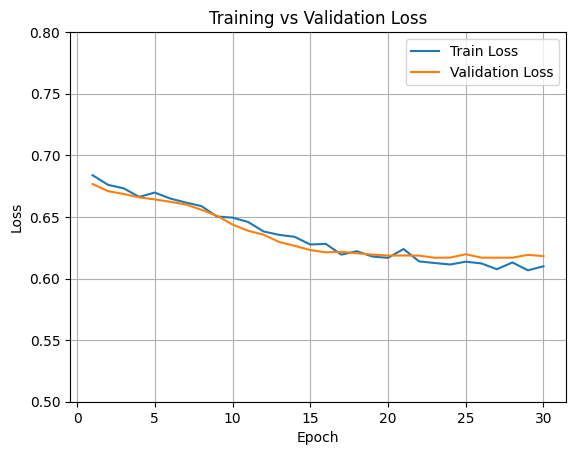


Final Test Accuracy: 68.46%

Classification Report:
              precision    recall  f1-score   support

 Not Potable       0.68      0.92      0.78       600
     Potable       0.72      0.31      0.43       383

    accuracy                           0.68       983
   macro avg       0.70      0.62      0.61       983
weighted avg       0.69      0.68      0.65       983



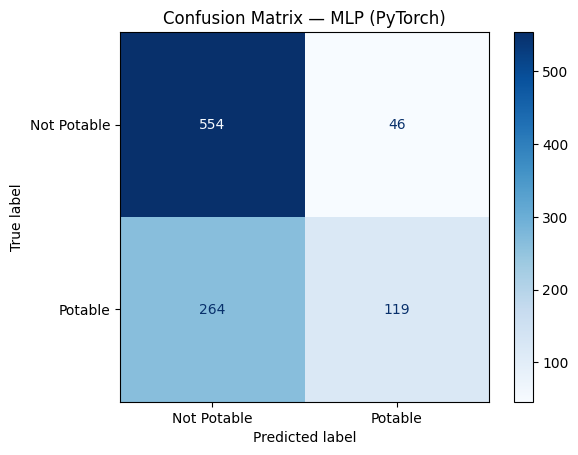


=== Порівняння точності моделей ===
        Model  Accuracy (%)
MLP (PyTorch)     68.463886
          SVM     68.140000
Random Forest     67.380000
          kNN     64.940000
     AdaBoost     63.870000


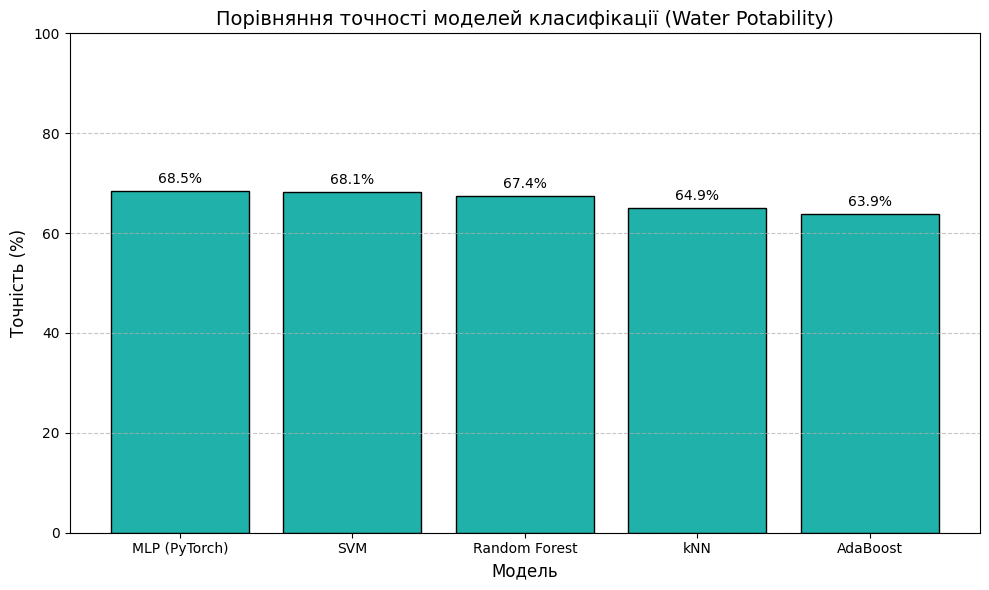

In [2]:
# === 1. Завантаження даних ===
url = "https://raw.githubusercontent.com/ilchukjulia059-cyber/NeuroLabs/refs/heads/main/Lab1/water_potability.csv"
df = pd.read_csv(url)
print("Розмір датасету:", df.shape)
print(df.head())

# === 2. Обробка пропусків ===
df.fillna(df.median(), inplace=True)

# === 3. Поділ на ознаки і ціль ===
X = df.drop(columns=['Potability']).values
y = df['Potability'].values

# === 4. Масштабування ===
scaler = StandardScaler()
X = scaler.fit_transform(X)

# === 5. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# === 6. Перетворення у тензори ===
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.long)

# === 7. DataLoader ===
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

# === 8. Архітектура MLP ===
class WaterMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)

model = WaterMLP(input_dim=X_train.shape[1]).to(device)
print(model)

# === 9. Функція втрат і оптимізатор ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === 10. Навчання ===
n_epochs = 30
train_loss_hist, val_loss_hist = [], []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

# === 11. Графік втрат ===
plt.plot(range(1, n_epochs+1), train_loss_hist, label="Train Loss")
plt.plot(range(1, n_epochs+1), val_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.ylim(0.5, 0.8)

plt.grid(True)
plt.show()

# === 12. Тестування ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nFinal Test Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Not Potable", "Potable"]))

# === 13. Матриця плутанини ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Potable", "Potable"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — MLP (PyTorch)")
plt.show()

# === 14. Порівняння з іншими моделями (з Лаб 1) ===
model_names = ["SVM", "Random Forest", "kNN", "AdaBoost", "MLP (PyTorch)"]
accuracies = [68.14, 67.38, 64.94, 63.87, acc*100]  # acc – точність твого MLP на тесті

df_compare = pd.DataFrame({
    "Model": model_names,
    "Accuracy (%)": accuracies
}).sort_values(by="Accuracy (%)", ascending=False)

print("\n=== Порівняння точності моделей ===")
print(df_compare.to_string(index=False))

# === 15. Візуалізація порівняння ===
plt.figure(figsize=(10, 6))
bars = plt.bar(
    df_compare["Model"],
    df_compare["Accuracy (%)"],
    color="lightseagreen",
    edgecolor="black"
)

plt.title("Порівняння точності моделей класифікації (Water Potability)", fontsize=14)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Точність (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# підписи над стовпчиками
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()


2. Згорткові нейронні мережі

In [3]:
!pip install kaggle

import os

# Введи свої username і key вручну
os.environ['KAGGLE_USERNAME'] = "ilchukyulia"
os.environ['KAGGLE_KEY'] = "GAT_f9119359f75b26ace5709a8ec17f3fbb"

# Завантаження датасету
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# === 0. Імпорт бібліотек ===
import os
import zipfile
import random
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# === 1. Розпакування датасету ===
zip_path = "/content/flowers-recognition.zip"
extract_path = "/content/flowers"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data_dir = os.path.join(extract_path, "flowers")
print("Папки з класами:", os.listdir(data_dir))

# === 2. Підготовка структури train/test ===
train_dir = os.path.join(extract_path, "train")
test_dir = os.path.join(extract_path, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Для кожного класу створюємо підпапки і копіюємо зображення
for cls in os.listdir(data_dir):
    cls_dir = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_dir):
        continue  # пропускаємо зайві елементи

    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if len(imgs) == 0:
        continue  # пропускаємо порожні папки

    random.shuffle(imgs)
    split_idx = int(0.8 * len(imgs))
    train_imgs = imgs[:split_idx]
    test_imgs  = imgs[split_idx:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))

print("✅ Train/Test дані підготовлені.")

# === 3. Перевірка та очищення структури ===
# Видаляємо порожні папки, якщо вони є
for root_dir in [train_dir, test_dir]:
    flowers_path = os.path.join(root_dir, "flowers")
    if os.path.exists(flowers_path) and len(os.listdir(flowers_path)) == 0:
        shutil.rmtree(flowers_path)
        print(f"🧹 Видалено порожню папку: {flowers_path}")

print("Train класи:", os.listdir(train_dir))
print("Test класи:", os.listdir(test_dir))
for cls in os.listdir(train_dir):
    cls_train = len(os.listdir(os.path.join(train_dir, cls)))
    cls_test = len(os.listdir(os.path.join(test_dir, cls)))
    print(f"{cls}: {cls_train} train / {cls_test} test")

# === 4. Трансформації ===
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# === 5. Створення датасетів ===
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transforms)

print(f"\nКількість зображень для тренування: {len(train_dataset)}")
print(f"Кількість зображень для тесту: {len(test_dataset)}")
print(f"Класи: {train_dataset.classes}")

# === 6. DataLoader ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\n✅ Дані повністю готові до навчання!")


Папки з класами: ['sunflower', 'rose', 'daisy', 'tulip', 'dandelion']
✅ Train/Test дані підготовлені.
Train класи: ['sunflower', 'rose', 'daisy', 'tulip', 'dandelion']
Test класи: ['sunflower', 'rose', 'daisy', 'tulip', 'dandelion']
sunflower: 732 train / 502 test
rose: 784 train / 528 test
daisy: 764 train / 512 test
tulip: 984 train / 662 test
dandelion: 1052 train / 707 test

Кількість зображень для тренування: 4316
Кількість зображень для тесту: 2911
Класи: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

✅ Дані повністю готові до навчання!


Використовується пристрій: cpu

=== Початок навчання SimpleCNN ===
[01/8] Train Loss: 1.2615 | Val Loss: 0.9921
[02/8] Train Loss: 1.0036 | Val Loss: 0.8962
[03/8] Train Loss: 0.8909 | Val Loss: 0.7752
[04/8] Train Loss: 0.7867 | Val Loss: 0.6398
[05/8] Train Loss: 0.6680 | Val Loss: 0.5326
[06/8] Train Loss: 0.5943 | Val Loss: 0.4408
[07/8] Train Loss: 0.4816 | Val Loss: 0.3478
[08/8] Train Loss: 0.4189 | Val Loss: 0.2824
⏱ Час навчання: 679.72 сек


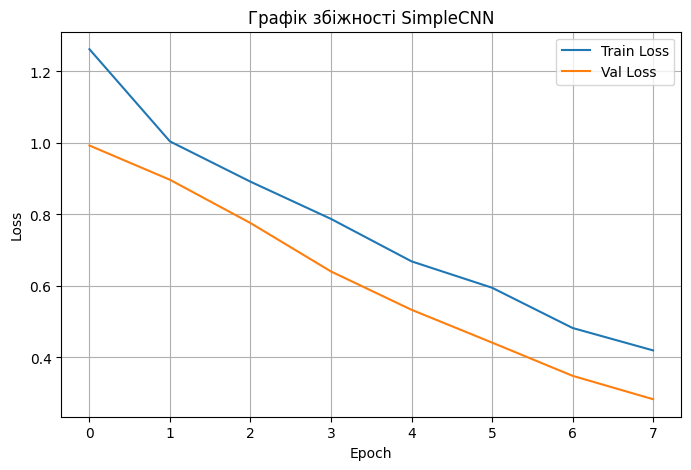


🎯 Точність SimpleCNN: 90.52%


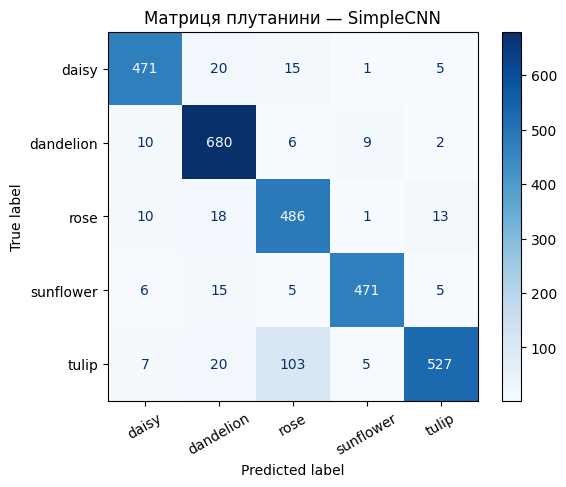

In [5]:
# === 1. Імпорт потрібного ===
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовується пристрій:", device)

# === 2. Архітектура простої CNN ===
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 32 * 32, 128),  # після двох пулінгів (128x128 → 32x32)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# === 3. Ініціалізація ===
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === 4. Навчання ===
n_epochs = 8
train_losses = []
val_losses = []

print("\n=== Початок навчання SimpleCNN ===")
start_time = time.time()

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Валідація
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"[{epoch+1:02d}/{n_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

end_time = time.time()
print(f"⏱ Час навчання: {(end_time - start_time):.2f} сек")

# === 5. Графік втрат ===
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Графік збіжності SimpleCNN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === 6. Оцінка моделі ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc_cnn = accuracy_score(all_labels, all_preds)
print(f"\n🎯 Точність SimpleCNN: {acc_cnn*100:.2f}%")

# === 7. Матриця плутанини ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap="Blues", xticks_rotation=30)
plt.title("Матриця плутанини — SimpleCNN")
plt.show()



=== Початок донавчання ResNet18 ===
[1/5] Train Loss: 1.4445 | Val Loss: 1.2289
[2/5] Train Loss: 1.1217 | Val Loss: 0.9907
[3/5] Train Loss: 0.9415 | Val Loss: 0.8700
[4/5] Train Loss: 0.8467 | Val Loss: 0.7789
[5/5] Train Loss: 0.7799 | Val Loss: 0.7225
⏱ Час навчання ResNet18: 1227.14 сек


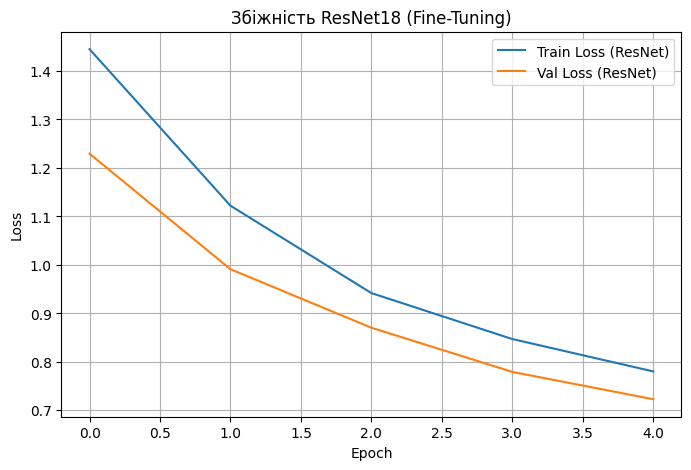


🎯 Точність ResNet18: 76.50%


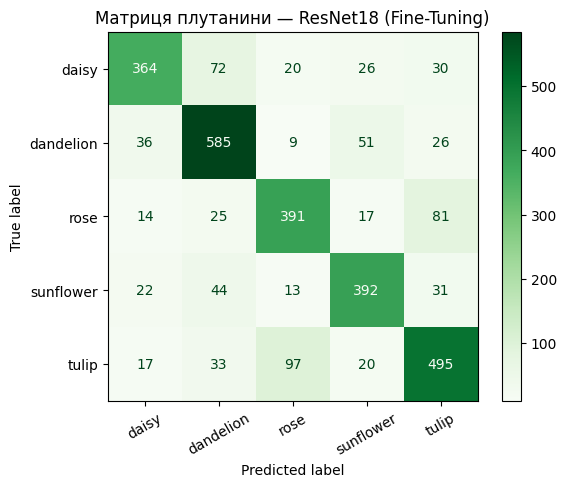


--- Порівняння моделей ---
SimpleCNN: 90.52%
ResNet18:  76.50%


In [6]:
# === 1. Імпорт ResNet18 ===
import torchvision.models as models

# Завантажуємо попередньо натреновану ResNet18
resnet = models.resnet18(weights="IMAGENET1K_V1")
resnet.fc = nn.Linear(resnet.fc.in_features, len(train_dataset.classes))  # під 5 класів
resnet = resnet.to(device)

# === 2. Фіксуємо більшість шарів (для швидшого навчання)
for param in resnet.parameters():
    param.requires_grad = False
# Розморожуємо тільки останні шари
for param in resnet.fc.parameters():
    param.requires_grad = True

# === 3. Оптимізатор і функція втрат ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-4)

# === 4. Навчання ===
n_epochs = 5
train_losses_resnet = []
val_losses_resnet = []

print("\n=== Початок донавчання ResNet18 ===")
start_time = time.time()

for epoch in range(n_epochs):
    resnet.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses_resnet.append(avg_train_loss)

    # Валідація
    resnet.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = resnet(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses_resnet.append(avg_val_loss)

    print(f"[{epoch+1}/{n_epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

end_time = time.time()
print(f"⏱ Час навчання ResNet18: {(end_time - start_time):.2f} сек")

# === 5. Графік втрат ===
plt.figure(figsize=(8,5))
plt.plot(train_losses_resnet, label="Train Loss (ResNet)")
plt.plot(val_losses_resnet, label="Val Loss (ResNet)")
plt.title("Збіжність ResNet18 (Fine-Tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === 6. Оцінка ResNet18 ===
resnet.eval()
all_preds_resnet, all_labels_resnet = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = resnet(imgs)
        preds = outputs.argmax(dim=1)
        all_preds_resnet.extend(preds.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

acc_resnet = accuracy_score(all_labels_resnet, all_preds_resnet)
print(f"\n🎯 Точність ResNet18: {acc_resnet*100:.2f}%")

# === 7. Матриця плутанини ===
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=train_dataset.classes)
disp.plot(cmap="Greens", xticks_rotation=30)
plt.title("Матриця плутанини — ResNet18 (Fine-Tuning)")
plt.show()

# === 8. Порівняння результатів ===
print("\n--- Порівняння моделей ---")
print(f"SimpleCNN: {acc_cnn*100:.2f}%")
print(f"ResNet18:  {acc_resnet*100:.2f}%")
